In [1]:
from Dataset import CustomDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from model import RiceDetector
from torchsummary import summary
import torch.optim
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
dataset = CustomDataset("Data/labels/label_csv.csv", "Data/images/")
len(dataset)

75000

In [3]:
train_len = int(len(dataset) * 0.8)
val_len = int(len(dataset) * 0.1)
test_len = int(len(dataset) * 0.1)
print(train_len)
print(val_len)
print(test_len)
train_data, val_data, test_data = random_split(dataset, lengths=[train_len, val_len, test_len])

60000
7500
7500


In [4]:
train_data.__getitem__(0)[0].shape

torch.Size([3, 250, 250])

In [5]:
train_loader, val_loader, test_loader = DataLoader(train_data, 64), DataLoader(val_data, 64), DataLoader(test_data, 1)

In [6]:
model = RiceDetector()
model.to("cuda")

RiceDetector(
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool_1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (pool_3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_4): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool_4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=21632, out_features=1024, bias=True)
  (fc_2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc_3): Linear(in_features=1024, out_features=5, bias=True)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (batch_norm_1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [7]:
log = pd.DataFrame(columns=["Epoch", "Train Loss", "Train Accuracy", "Validation Loss", "Validation Accuracy"])

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

total_train_loss = []
total_val_loss = []

best_model_val = 1
best_model = None

epochs = 5
for epoch in range(0, epochs):
    # Training
    model.train()
    totalTrainLoss = 0
    totalValLoss = 0
    trainCorrect = 0
    valCorrect = 0
    
    epoch_train_pred = []
    for x_batch, y_batch in tqdm(train_loader, desc="Train loop: "):
        optimizer.zero_grad()
        x_batch = x_batch.to("cuda")
        y_batch = y_batch.to("cuda")
        y_batch = nn.functional.one_hot(y_batch, 5).float().to("cuda")
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        totalTrainLoss += loss.item()
        optimizer.step()
        
        trainCorrect += (pred.argmax(1) == y_batch.argmax(1)).sum().item()
        
        
    # validation
    with torch.no_grad():
        model.eval()
        val_loss = 0.0
        valCorrect = 0
        for x_batch, y_batch in tqdm(val_loader, desc= "Validation loop: "):
            x_batch = x_batch.to("cuda")
            y_batch = y_batch.to("cuda")
            y_batch = nn.functional.one_hot(y_batch, 5).float().to("cuda")
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            totalValLoss += loss.item()
            
            valCorrect += (pred.argmax(1) == y_batch.argmax(1)).sum().item()
    
    # best model check
    if not best_model or valCorrect > best_model_val:
        best_model = model
        best_model_val = valCorrect
    
    # print for debug
    total_train_loss.append(totalTrainLoss/len(train_loader))
    total_val_loss.append(totalValLoss/len(val_loader))
    print("epoch {} , Train Loss: {}, Train Accuracy: {}, Val Loss: {}, Val Accuracy: {}".format(epoch, totalTrainLoss/len(train_loader), trainCorrect/len(train_data), totalValLoss/len(val_loader), valCorrect/len(val_data)))
    
    # Add to log
    epoch_data = [epoch, totalTrainLoss/len(train_loader), trainCorrect/len(train_data), totalValLoss/len(val_loader), valCorrect/len(val_data)]
    log.add(epoch_data)
    

Validation loop: 100%|██████████| 118/118 [00:15<00:00,  7.48it/s]


epoch 0 , Train Loss: 0.15731341531698798, Train Accuracy: 0.9438333333333333, Val Loss: 0.1162231081496861, Val Accuracy: 0.9618666666666666


Validation loop: 100%|██████████| 118/118 [00:17<00:00,  6.93it/s]


epoch 1 , Train Loss: 0.073023523439962, Train Accuracy: 0.9754333333333334, Val Loss: 0.048260959400006145, Val Accuracy: 0.9878666666666667


Validation loop: 100%|██████████| 118/118 [00:16<00:00,  7.05it/s]


epoch 2 , Train Loss: 0.03281056056245178, Train Accuracy: 0.9896833333333334, Val Loss: 0.0470575497454127, Val Accuracy: 0.9864


Validation loop: 100%|██████████| 118/118 [00:17<00:00,  6.85it/s]


epoch 3 , Train Loss: 0.029080730343948917, Train Accuracy: 0.9905166666666667, Val Loss: 0.023548394492906282, Val Accuracy: 0.9937333333333334


Validation loop: 100%|██████████| 118/118 [00:16<00:00,  7.10it/s]

epoch 4 , Train Loss: 0.02185827173758174, Train Accuracy: 0.9929833333333333, Val Loss: 0.020480550979007573, Val Accuracy: 0.9941333333333333


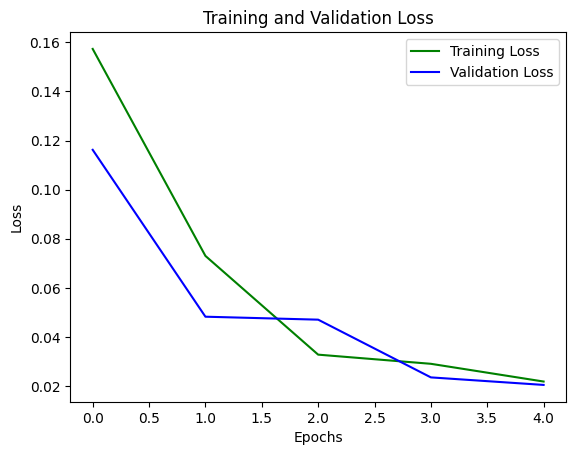

In [9]:
plt.plot(np.arange(0, epochs, 1), total_train_loss, 'g', label="Training Loss")
plt.plot(np.arange(0, epochs, 1), total_val_loss, 'b', label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [10]:
# save log
log.to_csv("Logs/log_1.csv")

In [11]:
with torch.no_grad():
        model.eval()
        testCorrect = 0
        for x_batch, y_batch in tqdm(test_loader, desc= "test loop: "):
            x_batch = x_batch.to("cuda")
            y_batch = y_batch.to("cuda")
            y_batch = nn.functional.one_hot(y_batch, 5).float().to("cuda")
            pred = model(x_batch)
            
            testCorrect += (pred.argmax(1) == y_batch.argmax(1)).sum().item()
        
        print("Test Accuracy: {}".format(testCorrect/len(test_loader)))

test loop: 100%|██████████| 7500/7500 [00:21<00:00, 348.27it/s]

Test Accuracy: 0.9941333333333333


In [12]:
torch.save(model.to("cpu").state_dict(), "models/model_2.pt")

In [13]:
model = RiceDetector()
model.load_state_dict(torch.load("models/model_2.pt"))
model.to("cuda")


RiceDetector(
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool_1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (pool_3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_4): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool_4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=21632, out_features=1024, bias=True)
  (fc_2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc_3): Linear(in_features=1024, out_features=5, bias=True)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (batch_norm_1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats